libraries :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Input,GlobalMaxPooling1D,Dropout,Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
import numpy as np
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf




Load data :

In [2]:
training=pd.read_csv("twitter_training.csv")
test=pd.read_csv("twitter_validation.csv")

In [3]:
training

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...


In [4]:
test

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...,...,...
994,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
997,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


Preprocessing Dataset :


In [5]:
test.columns = ['Header1', 'company','labels','text']
training.columns = ['Header1', 'company','labels','text']

In [6]:
print(training)
print(test)

       Header1      company    labels  \
0         2401  Borderlands  Positive   
1         2401  Borderlands  Positive   
2         2401  Borderlands  Positive   
3         2401  Borderlands  Positive   
4         2401  Borderlands  Positive   
...        ...          ...       ...   
74676     9200       Nvidia  Positive   
74677     9200       Nvidia  Positive   
74678     9200       Nvidia  Positive   
74679     9200       Nvidia  Positive   
74680     9200       Nvidia  Positive   

                                                    text  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized that my Mac wi

In [7]:
training.drop(columns=["Header1","company"],inplace=True)
test.drop(columns=["Header1","company"],inplace=True)

In [8]:
sentiment=pd.concat([training,test],ignore_index=True)
sentiment

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
75675,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,Positive,Today sucked so it’s time to drink wine n play...
75678,Positive,Bought a fraction of Microsoft today. Small wins.


In [9]:
sentiment.info()
sentiment.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  75680 non-null  object
 1   text    74994 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


labels      0
text      686
dtype: int64

In [10]:
sentiment.dropna(inplace=True)
sentiment.isnull().sum()


labels    0
text      0
dtype: int64

In [11]:
sentiment.duplicated().sum()

4743

In [12]:
sentiment.drop_duplicates(inplace=True)
sentiment.duplicated().sum()

0

In [13]:
def process_text(text):
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Remove extra white space from text

    text = re.sub(r'\W', ' ', str(text)) # Remove all the special characters from text

    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # Remove all single characters from text

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove any character that isn't alphabetical

    text = text.lower()

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    stop_words = set(stopwords.words("english"))
    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

In [14]:
x=sentiment.drop('labels',axis=1)
y=sentiment.labels

In [15]:
x=sentiment.drop('labels',axis=1)
y=sentiment.labels

In [16]:
texts=list(x['text'])
cleaned_text = [process_text(text) for text in texts]
print(cleaned_text[:10])


[['coming', 'border', 'kill'], ['getting', 'borderland', 'kill'], ['coming', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'couple', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'picture', 'compared', 'creation', 'made', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya

train_test_split :

In [17]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42)

Applying Tokenization :

In [18]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

the size of vocab = 24048


In [19]:
maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

Creating Model :

In [25]:
D=100
inputt=Input(shape=(maxlen,))
learning_rate = 0.0001  
x=Embedding(v+1,D)(inputt)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(150))(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputt, x)
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [28]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

In [33]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train_one_hot, epochs=20, validation_data=(X_test, y_test_one_hot))


Epoch 1/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 216s 121ms/step - accuracy: 0.6130 - loss: 0.9590 - val_accuracy: 0.7903 - val_loss: 0.5703
Epoch 2/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 221s 125ms/step - accuracy: 0.8316 - loss: 0.4565 - val_accuracy: 0.8441 - val_loss: 0.4203
Epoch 3/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 210s 120ms/step - accuracy: 0.8805 - loss: 0.3239 - val_accuracy: 0.8599 - val_loss: 0.3770
Epoch 4/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 212s 121ms/step - accuracy: 0.9001 - loss: 0.2652 - val_accuracy: 0.8690 - val_loss: 0.3570
Epoch 5/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 212s 121ms/step - accuracy: 0.9154 - loss: 0.2225 - val_accuracy: 0.8741 - val_loss: 0.3604
Epoch 6/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 214s 122ms/step - accuracy: 0.9264 - loss: 0.1940 - val_accuracy: 0.8821 - val_loss: 0.3388
Epoch 7/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 216s 123ms/step - accuracy: 0.9310 - loss: 0.1795 - val_accuracy: 0.8863 - val_loss: 0.3340
Epoch 8/20
1757/1757 ━━━━━━━━━━━━━━━━━━━━ 211s 120ms/step - ac

Model Evaluation  :
 

In [36]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

440/440 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8964 - loss: 0.4241
Test Loss: 0.4242866039276123
Test Accuracy: 0.898227870464325


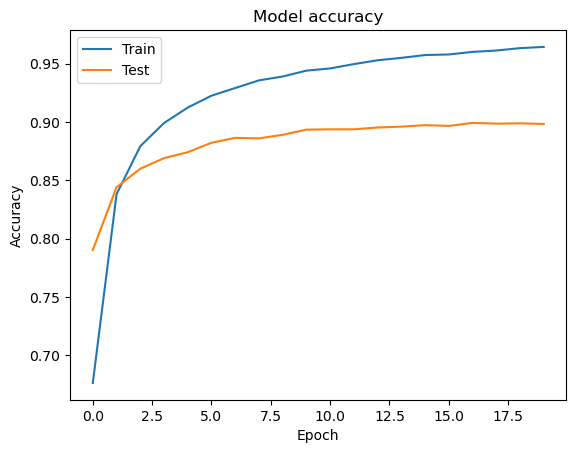

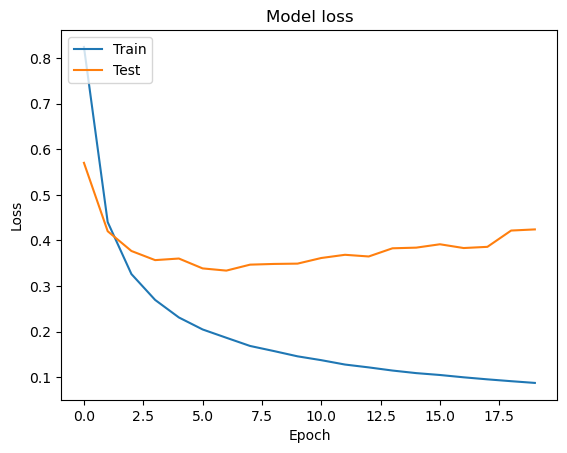

In [35]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()